In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [11]:
trades = pd.read_csv('round-4-island-data-bottle/trades_round_4_day_1.csv', sep=';').set_index('timestamp')
prices1 = pd.read_csv('round-4-island-data-bottle/prices_round_4_day_1.csv', sep=';').set_index('timestamp')
prices2 = pd.read_csv('round-4-island-data-bottle/prices_round_4_day_2.csv', sep=';').set_index('timestamp')
prices2.index = prices2.index + 1000000
prices3 = pd.read_csv('round-4-island-data-bottle/prices_round_4_day_3.csv', sep=';').set_index('timestamp')
prices3.index = prices3.index + 2000000
obs1 = pd.read_csv('round-4-island-data-bottle/observations_round_4_day_1.csv', sep=',').set_index('timestamp')
obs2 = pd.read_csv('round-4-island-data-bottle/observations_round_4_day_2.csv', sep=',').set_index('timestamp')
obs2.index = obs2.index + 1000000
obs3 = pd.read_csv('round-4-island-data-bottle/observations_round_4_day_3.csv', sep=',').set_index('timestamp')
obs3.index = obs3.index + 2000000

obs = pd.concat([obs1, obs2, obs3])
prices = pd.concat([prices1, prices2, prices3])

In [12]:
maca = prices.query('product == "MAGNIFICENT_MACARONS"')
SQUID = prices.query('product == "SQUID_INK"')

In [4]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0



In [7]:
hurst(SQUID['mid_price'].values)

0.44455092375024935

<Axes: xlabel='timestamp'>

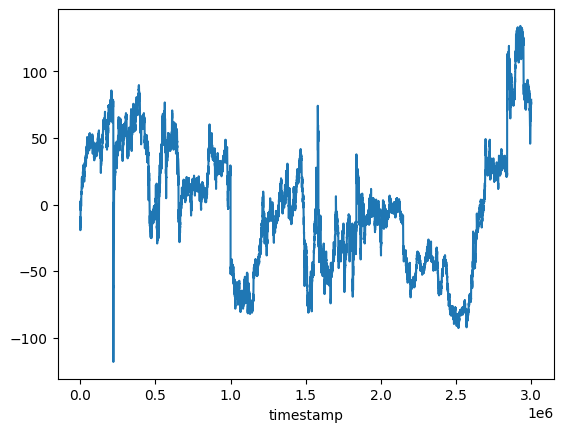

In [13]:
(SQUID['mid_price'] -SQUID['mid_price'].mean()).plot()

In [197]:
obs['net_buy'] = obs['askPrice'] +obs['transportFees'] - obs['importTariff']
obs['net_sell'] = obs['bidPrice'] - obs['transportFees'] - obs['exportTariff']

In [31]:
import statsmodels.api as sm

In [739]:
X = sm.add_constant(obs)[["const","transportFees","exportTariff","importTariff","sugarPrice","sunlightIndex"]]
y = (obs['bidPrice'] + obs['askPrice']) / 2

In [743]:
X['sunlightIndex'].plot(backend='plotly')

In [562]:
def get_return(ser):
    return ser.iloc[-1] / ser.iloc[0] - 1

In [752]:
n = 10
y_pct_fixed_h = y.groupby(y.index // (100 * n)).apply(get_return).shift(1)
y_fixed_h = y.groupby(y.index // (100 * n)).mean()
X_fixed_h = X.groupby(X.index // (100 * n)).mean()
X_pct_fixed_h = X.groupby(X.index // (100 * n)).apply(get_return).shift(1)


In [747]:
X_pct_fixed_h

,const,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
timestamp,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.055556,0.0,0.012872,0.002000
2,0.0,0.0,0.000000,0.0,-0.009640,0.002162
3,0.0,0.0,0.000000,0.0,-0.004302,0.001992
4,0.0,0.0,0.000000,0.0,-0.000281,0.001987
...,...,...,...,...,...,...
595,0.0,0.0,0.000000,0.0,0.000311,0.009423
596,0.0,0.0,0.000000,0.0,-0.005848,0.009333
597,0.0,0.0,0.000000,0.0,-0.002436,0.009245


In [748]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_fixed_h, y=X_fixed_h['sunlightIndex'], mode='markers', name='X', xaxis='x1', yaxis='y1'))

In [753]:
projected_sun = X_fixed_h['sunlightIndex'] + (X_fixed_h['sunlightIndex'].pct_change() * X_fixed_h['sunlightIndex']) * 100

fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=X_fixed_h.index, y=X_fixed_h['sugarPrice'].div(X_fixed_h['sugarPrice'].iloc[0]), mode='lines', name="sugar"), secondary_y=False)
fig.add_trace(go.Scatter(x=y_fixed_h.index, y=y_fixed_h.div(y_fixed_h.iloc[0]), mode='lines', name='macaron'), secondary_y=False)
fig.add_trace(go.Scatter(x=X_fixed_h.index, y=X_fixed_h['sunlightIndex'], mode='lines', name='sunlightIndex'), secondary_y=True)
fig.add_trace(go.Scatter(x=projected_sun.index, y=projected_sun, mode='lines', name='Projected sun'), secondary_y=True)
fig.add_hline(y=50, line_width=1, line_color="red", line_dash="dash", secondary_y=True)
# fig.add_vrect(x0=53, x1=97, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=129, x1=185, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=356, x1=367, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=512, x1=590, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vline(x=54, line_width=1, line_color="red", line_dash="dash")
# fig.add_vline(x=535, line_width=1, line_color="red", line_dash="dash")
# fig.add_vrect(x0=43, x1=86, line_width=0, fillcolor="green", opacity=0.2)
# fig.add_vrect(x0=121, x1=180, line_width=0, fillcolor="green", opacity=0.2)
# fig.add_vrect(x0=86, x1=121, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=180, x1=350, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=350, x1=361, line_width=0, fillcolor="green", opacity=0.2)
# fig.add_vrect(x0=361, x1=503, line_width=0, fillcolor="red", opacity=0.2)
# fig.add_vrect(x0=503, x1=581, line_width=0, fillcolor="green", opacity=0.2)
# fig.add_vrect(x0=581, x1=599, line_width=0, fillcolor="red", opacity=0.2)
fig.update_layout(title_text="Sugar Price and Sunlight Index")

In [738]:
prices['bid_volume_1'].plot(kind="bar", figsize=(20, 10), alpha=0.5)

KeyboardInterrupt: 

Exception ignored in: Traceback (most recent call last):
'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x13c74ee80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x13faf8540> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [455]:
X_fixed_h['sunlightIndex']

timestamp
0      60.0612
1      60.1862
2      60.3112
3      60.4364
4      60.5612
        ...   
595    52.7450
596    53.2450
597    53.7450
598    54.2450
599    54.7450
Name: sunlightIndex, Length: 600, dtype: float64

In [489]:
y_fixed_h.shift(1)

timestamp
0          NaN
1      650.975
2      653.520
3      624.730
4      618.985
        ...   
595    829.740
596    837.460
597    826.255
598    809.260
599    799.320
Length: 600, dtype: float64

In [504]:
X_fixed_h['sugarPrice']

timestamp
0      201.310356
1      201.666105
2      199.157295
3      199.129826
4      199.558333
          ...    
595    212.034957
596    210.717579
597    210.306436
598    210.709417
599    212.330273
Name: sugarPrice, Length: 600, dtype: float64

In [ ]:
X_fixed_h['sunlightIndex'].pct_change() * X_fixed_h['sunlightIndex']

In [727]:
X = pd.concat([X_fixed_h['sunlightIndex'].pct_change().rename('sun pct'),(y_fixed_h).pct_change()], axis=1).shift(1).dropna()
# X = y_fixed_h.shift(1).rename('y').dropna()X_fixed_h['transportFees'], X_fixed_h['exportTariff'], X_fixed_h['importTariff']
# X['A'] = 
X = sm.add_constant(X) 
y = (y_fixed_h).pct_change().loc[X.index].dropna() #> 0

In [728]:
pd.concat([X, y], axis=1)

,const,sun pct,0,0
timestamp,,,,
2,1.0,0.004160,-0.046593,-0.017914
3,1.0,0.004139,-0.017914,-0.037464
4,1.0,0.004125,-0.037464,-0.013456
5,1.0,0.004105,-0.013456,0.016903
6,1.0,0.004092,0.016903,0.030815
...,...,...,...,...
295,1.0,0.020621,-0.020358,0.007832
296,1.0,0.020204,0.007832,0.003007
297,1.0,0.019804,0.003007,-0.019925


In [706]:
#logistic regression
model=sm.Logit(y, X).fit()
model.summary()


ValueError: endog must be in the unit interval.

In [731]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     11.01
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.45e-05
Time:                        21:14:51   Log-Likelihood:                 617.20
No. Observations:                 298   AIC:                            -1228.
Df Residuals:                     295   BIC:                            -1217.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.632      0.528      -0.002       0.005
sun pct       -0.1926      0.068     -2.839      0.005      -0.326      -0.059
0              0.1819      0.057      3.202      0.002       0.070       0.294
==============================================================================
Omnibus:                        3.914   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.828
Skew:                           0.234   Prob(JB):                        0.147
Kurtosis:                       2.701   Cond. No.                         39.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='timestamp'>

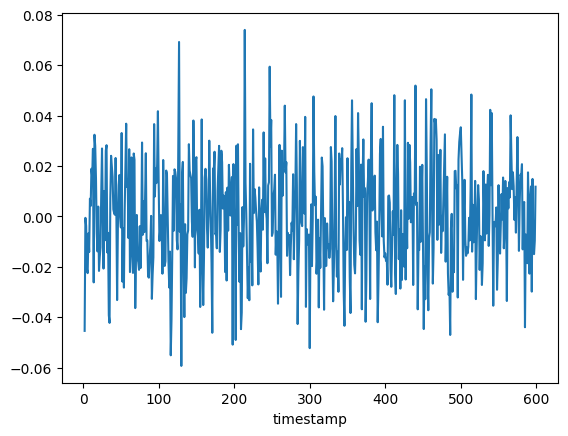

In [670]:
model.resid.plot()

In [319]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = pd.concat([X_fixed_h['sunlightIndex'],X_pct_fixed_h['sunlightIndex'].shift(1).rename('sun_pct')],axis=1).shift(1).dropna()
y = (y_fixed_h.shift(1).pct_change().dropna() > 0).loc[X.index].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=3)  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy:", model.score(X_test, y_test))

accuracy: 0.5652173913043478


In [322]:
#plot decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz

model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.49498327759197325

<Figure size 1000x600 with 0 Axes>

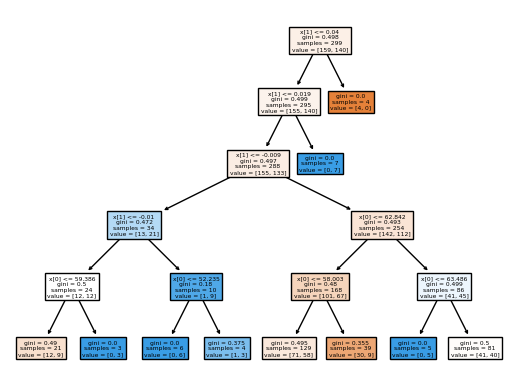

<Figure size 1000x600 with 0 Axes>

In [323]:
tree.plot_tree(model, filled=True)
plt.figure(figsize=(10, 6))

In [234]:
pd.concat([X, (y_fixed_h.pct_change()>0)], axis=1)

,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,0
timestamp,,,,,,
1,0.0,0.055556,0.0,0.012872,0.002000,True
2,0.0,0.000000,0.0,-0.009640,0.002162,False
3,0.0,0.000000,0.0,-0.004302,0.001992,False
4,0.0,0.000000,0.0,-0.000281,0.001987,False
5,0.0,0.000000,0.0,-0.006307,0.001983,False
...,...,...,...,...,...,...
596,0.0,0.000000,0.0,-0.005848,0.009333,False
597,0.0,0.000000,0.0,-0.002436,0.009245,False
598,0.0,0.000000,0.0,-0.003715,0.009159,False


In [223]:
import numpy as np

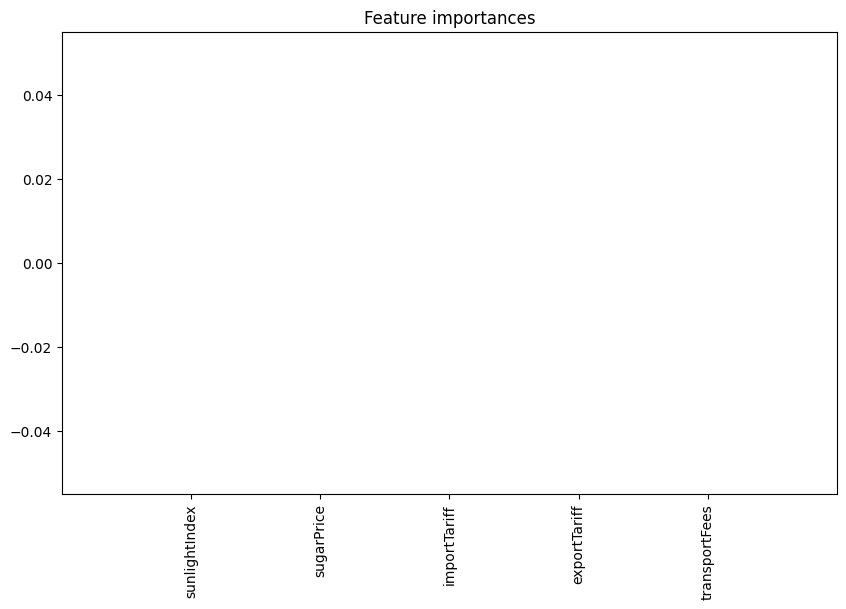

In [224]:
#plot feature importances
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [133]:
model = sm.OLS(y, X[['const','sugarPrice','sunlightIndex']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     6584.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:49:25   Log-Likelihood:                -51942.
No. Observations:               10000   AIC:                         1.039e+05
Df Residuals:                    9997   BIC:                         1.039e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           118.1122     18.227      6.480      0.000      82.383     153.842
sugarPrice        3.3275      0.079     42.126      0.000       3.173       3.482
sunlightIndex    -2.8357      0.053    -53.057      0.000      -2.940      -2.731
==============================================================================
Omnibus:                     1212.818   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.385
Skew:                          -0.144   Prob(JB):                     1.36e-76
Kurtosis:                       2.131   Cond. No.                     8.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='timestamp'>

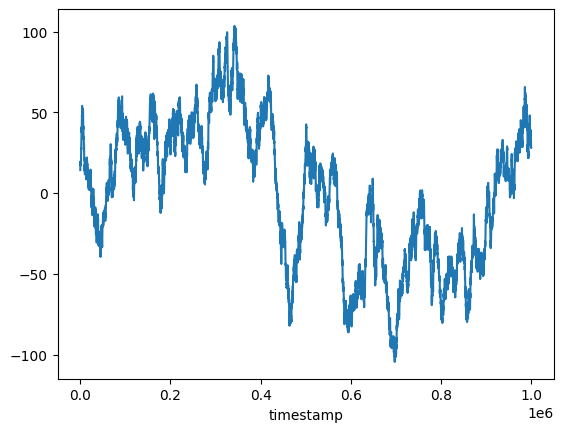

In [134]:
model.resid.plot()

In [49]:
#logistic regression
model = sm.Logit(y.pct_change().gt(0),X)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.690400
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:               0.0004873
Time:                        11:04:59   Log-Likelihood:                -6904.0
converged:                       True   LL-Null:                       -6907.4
Covariance Type:            nonrobust   LLR p-value:                    0.2413
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4996      1.035     -0.483      0.629      -2.529       1.530
transportFees    -0.1322      0.311     -0.425      0.671      -0.742       0.477
exportTariff     -0.0754      0.050     -1.496      0.135      -0.174       0.023
importTariff      0.0914      0.086      1.063      0.288      -0.077       0.260
sugarPrice        0.0075      0.006      1.320      0.187      -0.004       0.019
sunlightIndex     0.0003      0.003      0.111      0.912      -0.006       0.006
=================================================================================
"""

<Axes: xlabel='timestamp'>

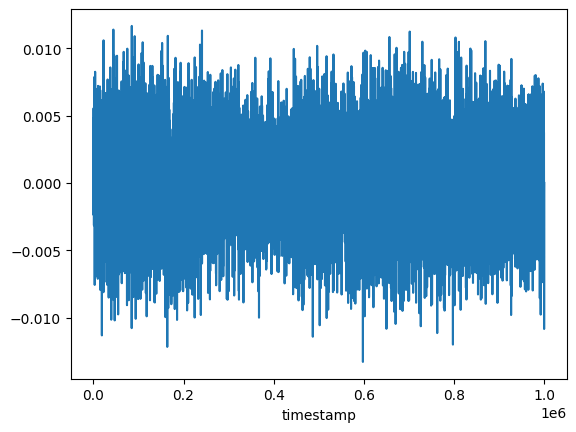

In [50]:
y.pct_change().plot()

<Axes: ylabel='Frequency'>

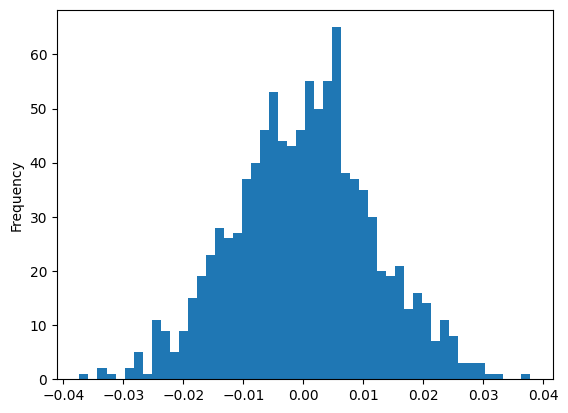

In [122]:
y.iloc[::10].pct_change().plot(kind='hist', bins=50)